In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn
import cv2
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from imutils import paths
from keras import metrics

Using TensorFlow backend.


In [2]:
data = []
labels = []

imagePaths = sorted(list(paths.list_images('/home/jailsonpereira/PAIC_CNN/dataset')))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(64,64))
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)
    

data = np.array(data,dtype='float32')/255
labels = np.array(labels)
print(data.shape)

(223, 64, 64, 3)


In [3]:
le=LabelEncoder()
labels=le.fit_transform(labels)
labels=to_categorical(labels,num_classes=2)

In [4]:
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,test_size=0.1)

In [5]:
vgg16_model=keras.applications.vgg16.VGG16(include_top=False,input_shape=(64,64,3))

In [6]:
vgg16_model.layers

In [7]:
model = Sequential()

In [8]:
for layers in vgg16_model.layers:
    model.add(layers)

In [9]:
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
#model.add(Dropout(0.5))

In [10]:
for layer in model.layers:
    layer.trainable=False

In [11]:
model.add(Dense(2,activation='sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       295168    
__________

In [13]:
opt = RMSprop(lr=0.001,rho=0.9,epsilon=1e-08,decay=0.0)

In [14]:
model.compile(opt,loss='binary_crossentropy',metrics=['acc'])

In [15]:
learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,minlr=0.00001)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=False,
        vertical_flip=False) 

datagen.fit(X_train)

In [17]:
history=model.fit_generator(datagen.flow(X_train,Y_train,batch_size=10),epochs=50,validation_data=(X_val,Y_val),
                          verbose=1,steps_per_epoch=X_train.shape[0]/10, callbacks=[learning_rate_reduction])

Epoch 1/50
20/20 [==============================] - 5s 266ms/step - loss: 0.6097 - acc: 0.7200 - val_loss: 0.5073 - val_acc: 0.7826
Epoch 2/50
20/20 [==============================] - 5s 247ms/step - loss: 0.5787 - acc: 0.7350 - val_loss: 0.5336 - val_acc: 0.8261
Epoch 3/50
20/20 [==============================] - 5s 250ms/step - loss: 0.5491 - acc: 0.7275 - val_loss: 0.4747 - val_acc: 0.7826
Epoch 4/50
20/20 [==============================] - 5s 255ms/step - loss: 0.5234 - acc: 0.7300 - val_loss: 0.4600 - val_acc: 0.7826
Epoch 5/50
20/20 [==============================] - 5s 255ms/step - loss: 0.5040 - acc: 0.7425 - val_loss: 0.4466 - val_acc: 0.8043

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
20/20 [==============================] - 5s 246ms/step - loss: 0.4734 - acc: 0.7650 - val_loss: 0.4395 - val_acc: 0.8261
Epoch 7/50
20/20 [==============================] - 5s 250ms/step - loss: 0.4658 - acc: 0.7650 - val_loss: 0.4988 - val_acc: 0.

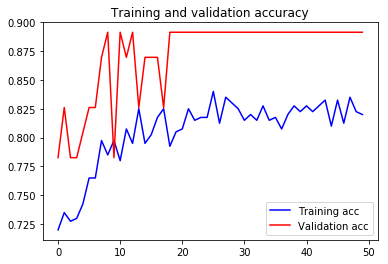

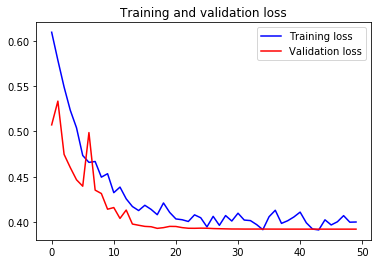

In [18]:
from matplotlib import pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()